In [1]:
# -*- coding: utf-8 -*
import os
import re
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.backend import tensorflow_backend
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import datasets
import scipy.linalg as LA
import cv2
import tensorflow as tf

/home/tsunei/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True))
session = tf.Session(config = config)
tensorflow_backend.set_session(session)

In [3]:
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

class ZCAWhitening:
  def __init__(self, epsilon=1E-0):
    #epsilon=1E-6=81%                                                                         
    #espilon=1E-1=88.7%                                                                       
    #espilon=1E-0=88.3%                                                                      
    #espilon=10=86%                                                                            
    self.epsilon = epsilon
    self.mean = None
    self.zca = None

  def fit(self, x):
    self.mean = np.mean(x, axis=0)
    x_ = x - self.mean
    print(x_.shape)
    cov = np.dot(x_.T, x_) / x_.shape[0]
    E, D, _ = np.linalg.svd(cov)
    D = np.sqrt(D) + self.epsilon
    self.zca = np.dot(E, np.dot(np.diag(1.0 / D), E.T))
    return self

  def transform(self, x):
    x_ = x - self.mean
    return np.dot(x_, self.zca.T)

In [4]:

X = []
Y = []
X_eva = []
Y_eva = []

# 学習データの取得（正解画像）
print("人工物画像の訓練データを取得してます...")
for filepath in list_pictures('../data/CNN_data/gakusyu/jinkou/'):
#for filepath in list_pictures('../temp_j/'):
    warnings.filterwarnings('ignore')
    img = img_to_array(load_img(filepath, grayscale=True, target_size=(128, 128)))        
    X.append(img)
    Y.append(0) # 教師データ（正解）

print("人工物画像の訓練データを取得しました")

    
# 学習データの取得（非正解画像）
print("自然物画像の訓練データを取得してます...")
for filepath in list_pictures('../data/CNN_data/gakusyu/sizen/'):
#for filepath in list_pictures('../temp_n/'):
    img = img_to_array(load_img(filepath, grayscale=True, target_size=(128, 128)))
    X.append(img)
    Y.append(1) # 教師データ（正解）

print("自然物画像の訓練データを取得しました")

#テストデータの所得
print("人工物画像のテストデータを取得してます...")
for filepath in list_pictures('../data/CNN_data/test/jinkou/'):
    img_eva = img_to_array(load_img(filepath, grayscale=True, target_size=(128, 128)))        
    X_eva.append(img_eva)
    Y_eva.append(0) # 教師データ（正解）

print("人工物画像のテストデータを取得しました")

    
# 学習データの取得（非正解画像）
print("自然物画像のテストデータを取得してます...")
for filepath in list_pictures('../data/CNN_data/test/sizen/'):
    img_eva = img_to_array(load_img(filepath, grayscale=True, target_size=(128, 128)))
    X_eva.append(img_eva)
    Y_eva.append(1) # 教師データ（正解）

print("自然物画像のテストデータを取得しました")

# NumPy配列に変換
X = np.asarray(X)
Y = np.asarray(Y)
X_eva = np.asarray(X_eva)
Y_eva = np.asarray(Y_eva)

#X = X.reshape(X.shape[0], 128, 128)   
#X_eva = X_eva.reshape(X_eva.shape[0], 128, 128)
    

# float32型に変換
X = X.astype('float32')
X_eva = X_eva.astype('float32')
cv2.imwrite('detected.png', X[0])

# 正規化(0～1)
X = X / 255.0
X_eva = X_eva / 255.0


人工物画像の訓練データを取得してます...
人工物画像の訓練データを取得しました
自然物画像の訓練データを取得してます...
自然物画像の訓練データを取得しました
人工物画像のテストデータを取得してます...
人工物画像のテストデータを取得しました
自然物画像のテストデータを取得してます...
自然物画像のテストデータを取得しました


In [5]:
#X = np.load('train_gray.npy')
#X_eva = np.load('test_gray.npy')
#Y = np.load('train_label_gray.npy')
#Y_eva = np.load('test_label_gray.npy')

In [6]:
#np.save('train_gray.npy', X)
#np.save('test_gray.npy', X_eva)
print("訓練データをzca白色化しています...")
#訓練データにzca白色化
#x_zcaw = X.reshape(X.shape[0], -1)
#zcaw = ZCAWhitening().fit(x_zcaw)
#x_zcaw = zcaw.transform(x_zcaw).reshape(X.shape)
datagen = ImageDataGenerator(zca_whitening=True)
g = datagen.flow(X, Y, X.shape[0], shuffle=False)
x_zcaw, Y = g.next()
print(x_zcaw.shape)
print(Y.shape)
print("訓練データをzca白色化しました")

print("テストデータをzca白色化しています...")
#テストデータにzca白色化
#x_zcaw_eva = X_eva.reshape(X_eva.shape[0], -1)
#zcaw_eva = ZCAWhitening().fit(x_zcaw_eva)
#x_zcaw_eva = zcaw_eva.transform(x_zcaw_eva).reshape(X_eva.shape)
datagen = ImageDataGenerator(zca_whitening=True)
g = datagen.flow(X_eva, Y_eva, X_eva.shape[0], shuffle=False)
x_zcaw_eva, Y_eva = g.next()
print(x_zcaw_eva.shape)
print(Y_eva.shape)
print("テストデータをzca白色化しました")
  
#X_white = X.reshape(X.shape[0], 128, 128, 1)
#X_eva_white = X_eva.reshape(X_eva.shape[0], 128,  128, 1)
    
    
# クラスの形式を変換
#Y = np_utils.to_categorical(Y, 2)
#y_train = Y
#y_test = Y

Y = np_utils.to_categorical(Y)
Y_eva = np_utils.to_categorical(Y_eva)
#np.save('train_label_gray.npy', Y)
#np.save('test_label_gray.npy', Y_eva)

#x_train, x_test, y_train, y_test = train_test_split(X_white, Y, test_size=0.175)
    
# 学習用データとテストデータに分割
x_train = x_zcaw
x_test = x_zcaw_eva
y_train = Y
y_test = Y_eva

訓練データをzca白色化しています...
(29894, 128, 128, 1)
(29894,)
訓練データをzca白色化しました
テストデータをzca白色化しています...
(2400, 128, 128, 1)
(2400,)
テストデータをzca白色化しました


In [7]:
batch_size = 128 # バッチサイズ(データサイズ)
num_classes = 2 # 分類クラス数(今回は0～9の手書き文字なので10)
epochs = 100 # エポック数(学習の繰り返し回数)
    
# モデルの構築
model = Sequential()

# Dense：全結合のニューラルネットワークレイヤー
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
#model.add(Dropout(0.2)) # 過学習防止用：入力の20%を0にする（破棄）
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
#model.add(Dropout(0.2)) # 過学習防止用：入力の20%を0にする（破棄）
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
#model.add(Dropout(0.2)) # 過学習防止用：入力の20%を0にする（破棄）
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
#model.add(Dropout(0.2)) # 過学習防止用：入力の20%を0にする（破棄）
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu')) # 活性化関数：relu
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
#model.add(layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
#model.add(Dropout(0.2)) # 過学習防止用：入力の20%を0にする（破棄）
model.add(layers.Dense(num_classes, activation='sigmoid')) # 活性化関数：softmax

model.summary()

# コンパイル（多クラス分類問題）
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# 構築したモデルで学習
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

model.save('main_gray_temp.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
__________

29894/29894 [==============================] - 78s 3ms/step - loss: 0.0238 - acc: 0.9914
Epoch 45/100
29894/29894 [==============================] - 78s 3ms/step - loss: 0.0249 - acc: 0.9915
Epoch 46/100
29894/29894 [==============================] - 79s 3ms/step - loss: 0.0217 - acc: 0.9929
Epoch 47/100
29894/29894 [==============================] - 79s 3ms/step - loss: 0.0220 - acc: 0.9930
Epoch 48/100
29894/29894 [==============================] - 79s 3ms/step - loss: 0.0234 - acc: 0.9922
Epoch 49/100
29894/29894 [==============================] - 78s 3ms/step - loss: 0.0234 - acc: 0.9923
Epoch 50/100
29894/29894 [==============================] - 79s 3ms/step - loss: 0.0213 - acc: 0.9929
Epoch 51/100
29894/29894 [==============================] - 78s 3ms/step - loss: 0.0208 - acc: 0.9933
Epoch 52/100
29894/29894 [==============================] - 78s 3ms/step - loss: 0.0197 - acc: 0.9938
Epoch 53/100
29894/29894 [==============================] - 78s 3ms/step - loss: 0.0188 - acc: 

2400/2400 [==============================] - 3s 1ms/step
Test loss: 0.6865328623254539
Test accuracy: 0.9197916666666667


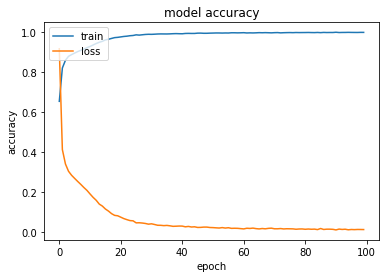

人工物画像 94.91666666666667 %
自然物画像 89.0 %
全体画像 91.95833333333333 %


In [8]:
# モデルの検証・性能評価
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

label = model.predict(x_test)
    
y_pred = model.predict_classes(x_test)

sum_j = 0
sum_s = 0
for i in range(x_test.shape[0]):
    if i < (x_test.shape[0] / 2):
        if y_pred[i] == 0:
            sum_j = sum_j + 1
            
    else:
        if y_pred[i] == 1:
            sum_s = sum_s + 1
                     
print("人工物画像",sum_j / (x_test.shape[0] / 2) * 100,"%")
print("自然物画像",sum_s / (x_test.shape[0] / 2) * 100,"%")
print("全体画像",(sum_s + sum_j) / x_test.shape[0] * 100,"%")